### Example: running a Sobel edge detection filter on a single image

In this notebook, we'll show how to apply a single filter (Sobel edge detection) to an image using the `max_cv` library. This library is built on the [MAX framework](https://docs.modular.com/max/) with kernels written in [Mojo](https://docs.modular.com/mojo/manual/). The API for `max_cv` is written in Python for easy integration with existing Python codebases or notebooks like this one.

We'll start by adding the local search path for the `max_cv` module.

In [1]:
import os
import sys
path_root = os.path.abspath(os.path.join('../'))
sys.path.append(str(path_root))

and then importing the modules we will need to define our image processing pipeline:

In [2]:
from max_cv import ImagePipeline, load_image_into_tensor
from max_cv import operations as ops
from max.driver import Accelerator, accelerator_count, CPU
from max.dtype import DType
from pathlib import Path
from PIL import Image

MAX allows for writing code that runs across CPUs, GPUs, and more. We'll set up this example to run on an attached GPU, if available, and fall back to running on a CPU if not. Note that no other code needs to be changed anywhere in order to switch between these hardware architectures.

In [3]:
device = CPU() if accelerator_count() == 0 else Accelerator()

Let's load an initial image into a MAX Tensor. By default, this will reside on the host (CPU), but you can also provide a device to load the image Tensor onto if you want to go directly to an accelerator.

In [4]:
image_path = Path("./resources/bucky_birthday_small.jpeg")
input_image_tensor = load_image_into_tensor(image_path)

We can convert this MAX Tensor to a NumPy array and display it, to see the original image:

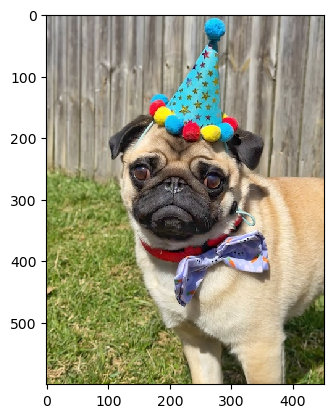

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
input_image_array = input_image_tensor.to_numpy()
plt.imshow(input_image_array, interpolation='nearest')
plt.show()

and then move it onto the accelerator, if we're using one:

In [6]:
input_image_tensor = input_image_tensor.to(device)

Now we'll construct the actual image processing pipeline. In this case, it has a few simple steps: take in an image, reduce it to just the luminance channel (grayscale), perform Sobel edge detection, and then return the result. [Sobel edge detection](https://en.wikipedia.org/wiki/Sobel_operator) analyzes the luminance gradients in X and Y near each image pixel and converts that to an edge strength. The default edge strength from this filter is reflected by a brighter pixel, and that strength can be scaled using an input parameter.

In [7]:
with ImagePipeline(
    "sobel_edge_detection",
    input_image_tensor.shape,
    pipeline_dtype=DType.float32
) as pipeline:
    processed_image = ops.rgb_to_luminance(pipeline.input_image)
    processed_image = ops.sobel_edge_detection(processed_image, strength=1.0)
    pipeline.output(processed_image)

H: 600 W: 450 C: 3


Under the hood, `ImagePipeline` constructs a computational graph using MAX from a combination of standard MAX operators and custom ones written in Mojo within `max_cv`. It automatically converts from 8-bit unsigned integer values to whatever you specify as the internal datatype (32-bit floats in this case), stages all computations, and then converts the values back to integer RGB images for output. The MAX Tensors can stay resident on the accelerator to be chained with AI models or more.

MAX uses an optimizing graph compiler to achieve high performance across a wide variety of hardware. In the above, we've staged a computational graph and we now need to compile it. Compilation only needs to be performed once per pipeline, and then as many images as you want can be run through the compiled pipeline. 

In [8]:
pipeline.compile(device)

Once compiled, the pipeline can be run against our input image:

In [9]:
output_image_tensor = pipeline(input_image_tensor)

We can then move the tensor from the device back to the host, and display the result:

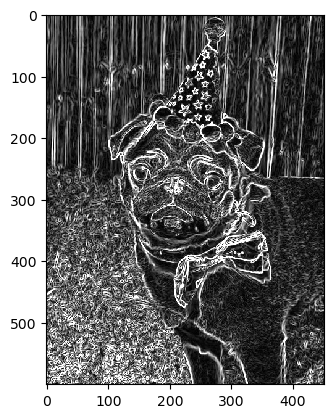

In [10]:
output_image_tensor = output_image_tensor.to(CPU())
output_image_tensor = output_image_tensor.to_numpy()
plt.imshow(output_image_tensor, interpolation='nearest')
plt.show()